In [14]:
import json
import multiprocessing as mp
from timeit import default_timer as timer

import cv2
from skimage import morphology
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from cityscapes import *
from IPython.display import display, clear_output

In [15]:
def disp2depth(disp, cam):
    # convert disparity to depth
    mask = disp != 0
    disp = mask * ((disp.astype(np.float32)-1.) / 255.)
    with np.errstate(divide='ignore'):
        depth = (cam['extrinsic']['baseline'] * cam['intrinsic']['fx']) / disp
    depth[disp == 0] = 0
#     depth[annot == name2label['sky'].id] = np.Inf
    
    #remove specks and fill in unknown values
#     depth = cv2.medianBlur(depth, 5)
#     depth = depth * morphology.remove_small_objects(depth != 0, min_size=1000, connectivity=2)
#     depth = cv2.inpaint(depth.astype(np.float32), (disp == 0).astype(np.uint8), 3, cv2.INPAINT_NS)
    return depth

In [27]:
def shrink(data, threshold, axis):
    dmin = data.min(axis)
    s = np.where(dmin < threshold)[0]
    return len(dmin) if s.size == 0 else s[0]

def new_bb(depth, depth_human, bb, bb_vis):
    x,y,w,h = bb
    x_min,x_max,y_min,y_max = ( max(x,0), min(x+w,depth.shape[1]),
                                max(y,0), min(y+h,depth.shape[0]) )
    x_vis, y_vis, w_vis, h_vis = bb_vis
    threshold = depth_human[y_vis:y_vis+h_vis,x_vis:x_vis+w_vis].min()
    s_top = s_right = s_bottom = s_left = 0
    if y_min < y_vis:
        s_top = shrink(depth[y_min:y_vis,x_vis:x_vis+w_vis], threshold, axis=1)
    if y_max > y_vis + h_vis:
        s_bottom = shrink(
            np.flipud(depth[y_vis+h_vis:y_max,x_vis:x_vis+w_vis]),
            threshold, axis=1)
    if x_min < x_vis:
        s_left = shrink(depth[y_vis:y_vis+h_vis,x_min:x_vis], threshold, axis=0)
    if x_max > x_vis + w_vis:
        s_right = shrink(
            np.fliplr(depth[y_vis:y_vis+h_vis,x_vis+w_vis:x_max]),
            threshold, axis=0)
    return ( x+s_left, y+s_top, w-s_left-s_right, h-s_top-s_bottom )

In [28]:
dataset_path = '/home/c276huan/bayesian-segmentation/models/deeplab/datasets/cityscapes'

In [29]:
name = 'cologne_000008_000019'

city = name.split('_')[0]
img_path   = dataset_path + '/leftImg8bit/train/' + city + '/' + name + '_leftImg8bit.png'
annot_path = img_path.replace('leftImg8bit.png', 'gtFine_labelIds.png')\
                     .replace('leftImg8bit', 'gtFine')
disp_path  = img_path.replace('leftImg8bit', 'disparity')
cam_path   = img_path.replace('leftImg8bit', 'camera') \
                         .replace('.png', '.json')
bbox_path  = img_path.replace('leftImg8bit', 'gtBboxCityPersons')\
                         .replace('.png', '.json')

img   = cv2.imread(img_path)
disp  = cv2.imread(disp_path,  cv2.IMREAD_UNCHANGED)
annot = cv2.imread(annot_path, cv2.IMREAD_UNCHANGED)
with open(cam_path, 'r') as cam_file:
    cam = json.load(cam_file)
# Depth map
depth = disp2depth(disp, cam)
with open(bbox_path, 'r') as f:
    bbox = json.load(f)

In [41]:
occluded = []

for obj in bbox['objects']:
    if name2labelCp[obj['label']].ignoreInEval:
        continue
    x, y, w, h = obj['bbox']
    x_vis, y_vis, w_vis, h_vis = obj['bboxVis']
    # Compute occlusion level
    occlusion = (1 - (w_vis*h_vis) / (w*h)) * 100
#     if occlusion == 0:
#         continue
    occluded.append(obj)

In [42]:
len(occluded)

12

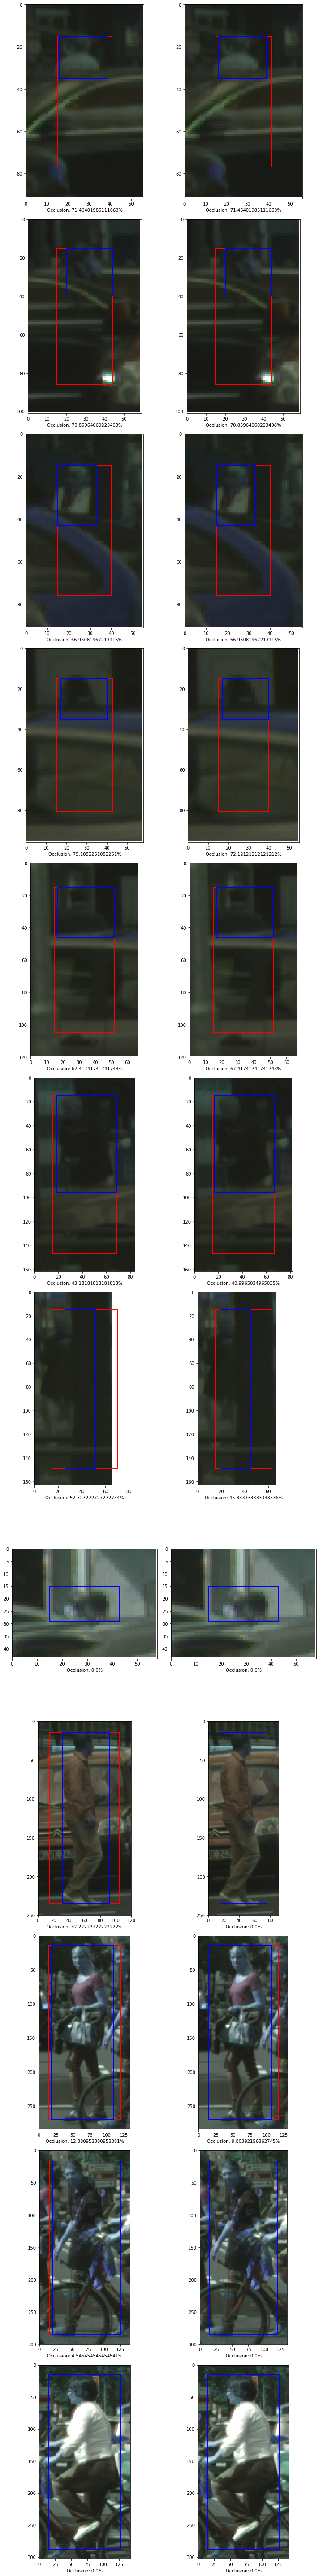

In [51]:
ROW = 12
COL = 2
MARGIN = 15

plt.figure(figsize=(10,80))

depth[depth == 0] = depth.max()
depth_human = depth * ( (annot==24)|(annot==25) )
depth_human[depth_human == 0] = depth.max()
depth_nobj = depth * ( (annot!=24)&(annot!=25)&(annot!=7)&(annot!=8)&(annot!=9)&(annot!=10) )
depth_nobj[depth_nobj == 0] = depth.max()


def plot(i, bb, bb_vis):
    x,y,w,h = bb
    x_vis,y_vis,w_vis,h_vis = bb_vis
    occlusion = (1 - (w_vis*h_vis) / (w*h)) * 100
    ax = plt.subplot(ROW,COL,i)
    ax.imshow(img[max(y-MARGIN,0):y+h+MARGIN,max(x-MARGIN,0):x+w+MARGIN])
    ax.add_patch(
        Rectangle((MARGIN,MARGIN), w, h, linewidth=2, edgecolor='red', facecolor='none')
    )
    ax.add_patch(
        Rectangle((x_vis-x+MARGIN, y_vis-y+MARGIN), w_vis, h_vis, linewidth=2, edgecolor='blue', facecolor='none')
    )
    ax.set_xlim(0, w+2*MARGIN)
    ax.set_ylim(h+2*MARGIN, 0)
    ax.set_xlabel('Occlusion: ' + str(occlusion) + '%')


for i,obj in enumerate(occluded):
    plot(1+i*2, obj['bbox'], obj['bboxVis'])
    plot(2+i*2, new_bb(depth_nobj, depth_human, obj['bbox'], obj['bboxVis']), obj['bboxVis'])

plt.tight_layout()
plt.show()